# A guide through BeautifulSoup

We will go through the usage of `BeautifulSoup` (and `requests`) with an example similar to the previous one. A key difference will be in the way we make our request. We will also have to be a bit more creative to find the "correct" site to scrape.

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

## 1. Requesting a website

As a reminder, let's start by requesting the website that we have used in the previous `BeautifulSoup` example. The three things happening here are:
- We request the page, using its URL and the `requests` package
- We parse the page with `BeautifulSoup` (from the `bs4` library)
- We then print out the `BeautifulSoup` "result", where `.prettify()` adds indentation and, thus, readability.

In [ ]:
url = "https://www.aldirecruitment.co.uk/head-office"
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")
print(soup.prettify())

Our task will be to gether prices on women's tops in the H&M online store (the category has been chosen completely at random).

The url is https://www2.hm.com/en_gb/ladies/shop-by-product/tops.html. Let's try to request the page as we did before:

In [ ]:
url = "https://www2.hm.com/en_gb/ladies/shop-by-product/tops.html"
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")
print(soup.prettify())

Access was denied! Usually, this is when web servers only alllow calling up a website using the "right" program (such as a recognized Browser with a sufficiently up-to-date version). How does the server know what is calling the request? This is where the "request header" comes in. Luckily, in many cases it's sufficient to call a website from our browser, and copy some of the information that are being sent. Usually, just the "user-agent field is enough":

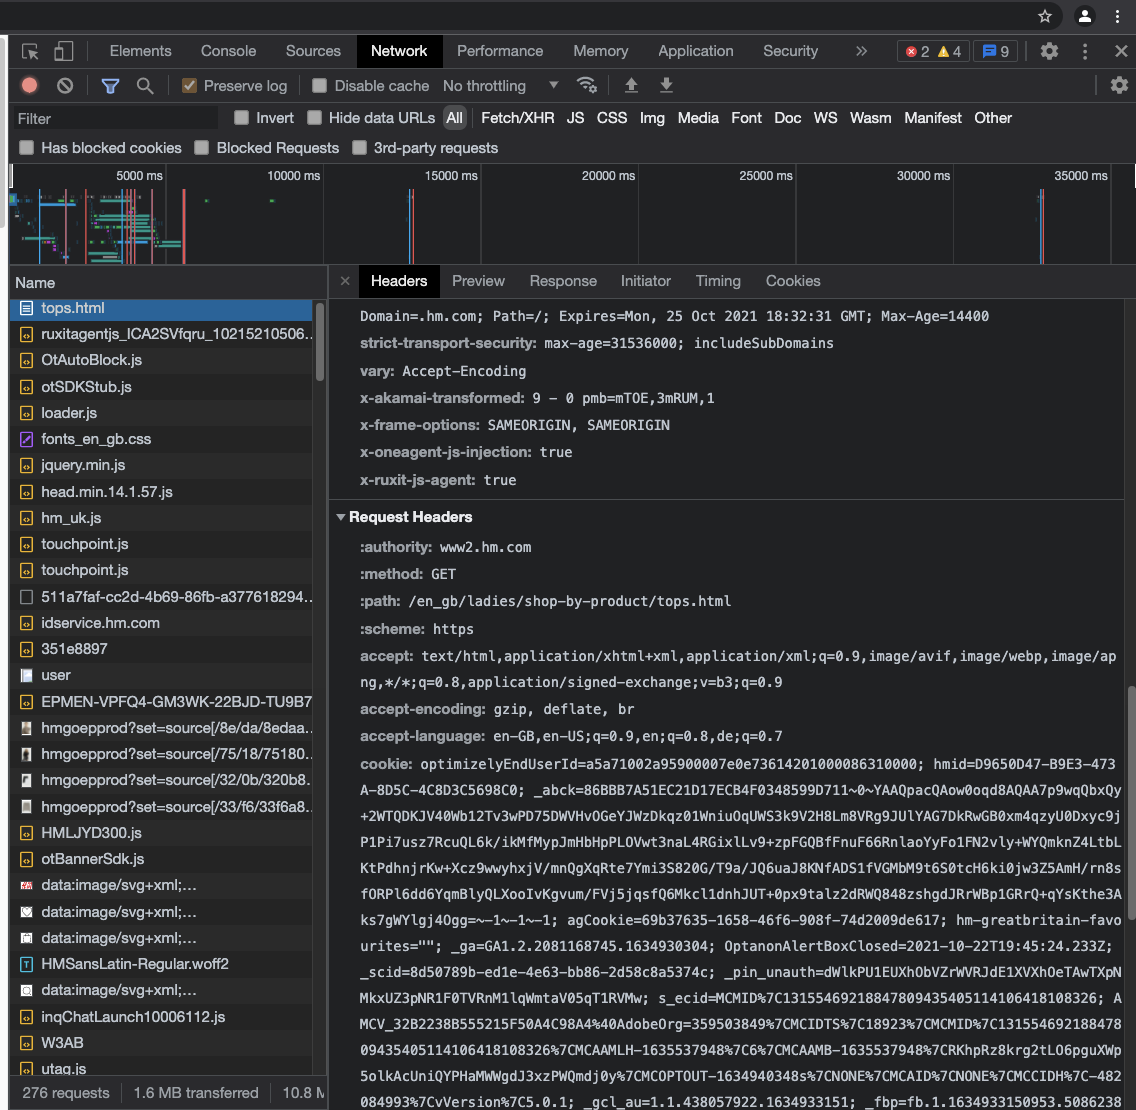

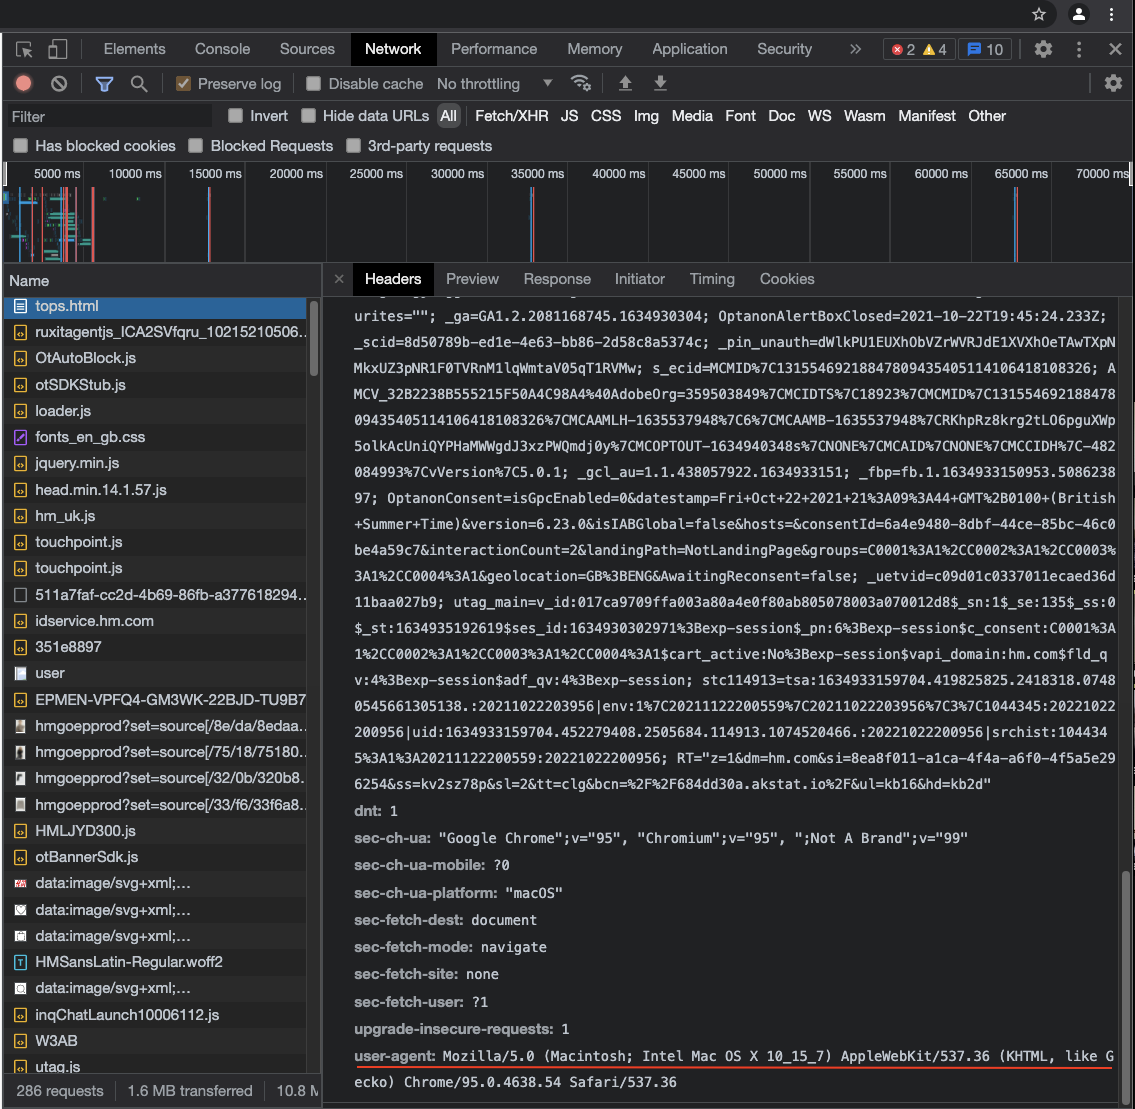

In [ ]:
headers = {"User-agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.54 Safari/537.36"}
page = requests.get(url,headers=headers)
soup = BeautifulSoup(page.content, "html.parser")
print(soup.prettify())

This looks more promising!

## 2. Finding links on the site

We can see that each top comes with a link, so let's try to see if we could get the relevant information using these links. Recall that links come in a-tags, and `BeautifulSoup` allows us to find the first a-tag on the site with `.find('a')`:

In [ ]:
tag = soup.find('a')
tag

More precisely, the link is within the "href" attribute (we call up attribute with `.get('href')`).

In [ ]:
tag.get('href')

Let's not just look at the first link, but at all links. We get all the a-tags by using `.findAll('a')`:

In [ ]:
a_tags = soup.findAll('a')
a_tags

Again, we can get the links themselves with `.get('href')`. Here, we simply run through the list of a-tags and take the `href` of each tag:

In [ ]:
links = []
for a in a_tags:
    links.append(a.get('href'))
print(links)

There are a lot of links here, most of which are not really helpful for our purposes. However, we can find through inspection that the actual links we care about have a quite specific class: "item-link":

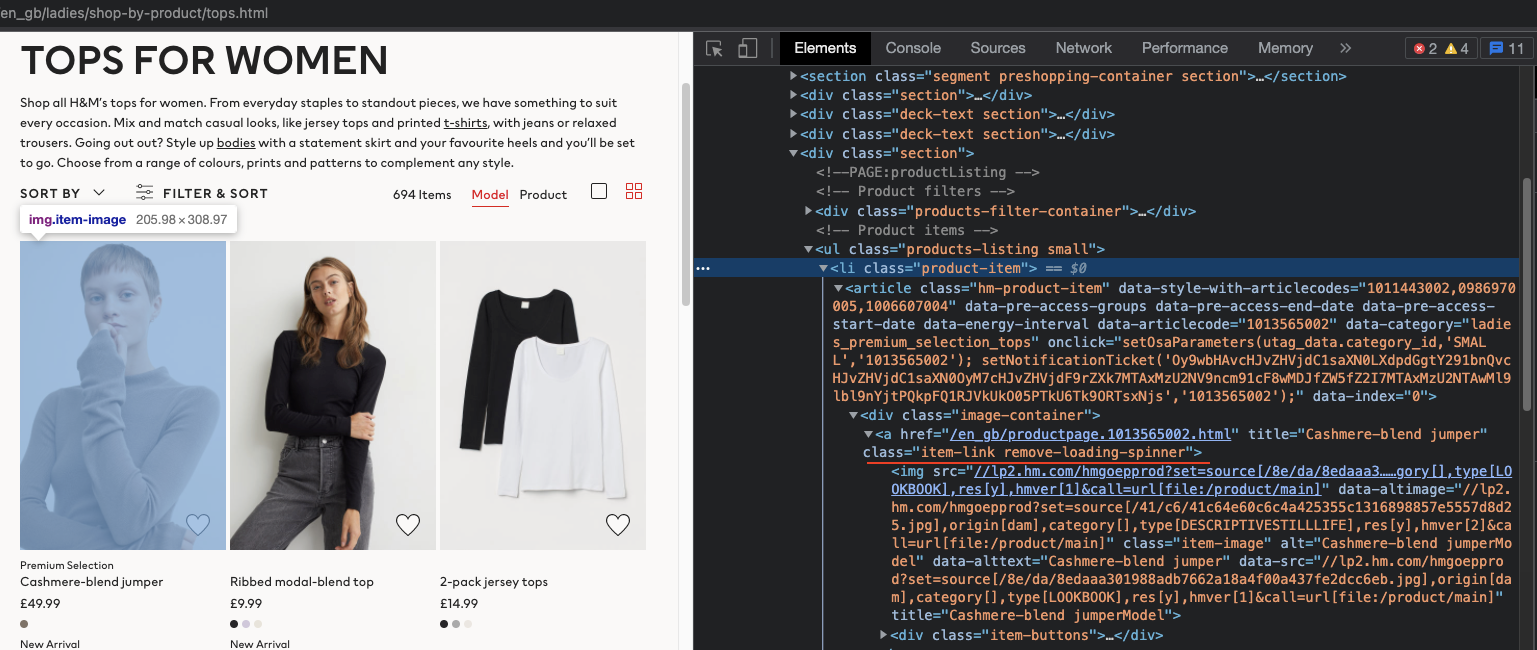

We make use of this by specifying a `class_` input to the `.find()` method.

In [ ]:
item_link_tag = soup.find('a',class_="item-link")
item_link_tag

It seems we got the first item! Let's take a look at its link:

In [ ]:
item_link_tag.get('href')

A quick side note: We don't have to search by class, we can also search by any other attribute. However, this requies us to specify a dictionary of attributes to search by:

In [ ]:
soup.find('a',attrs={"title" : "Cashmere-blend jumper"})

## 3. Finding other types of tags

We can use these links to search for items. However, inspecting the site, it seems more reasonable to search the li-tags (list items) representing the different products:

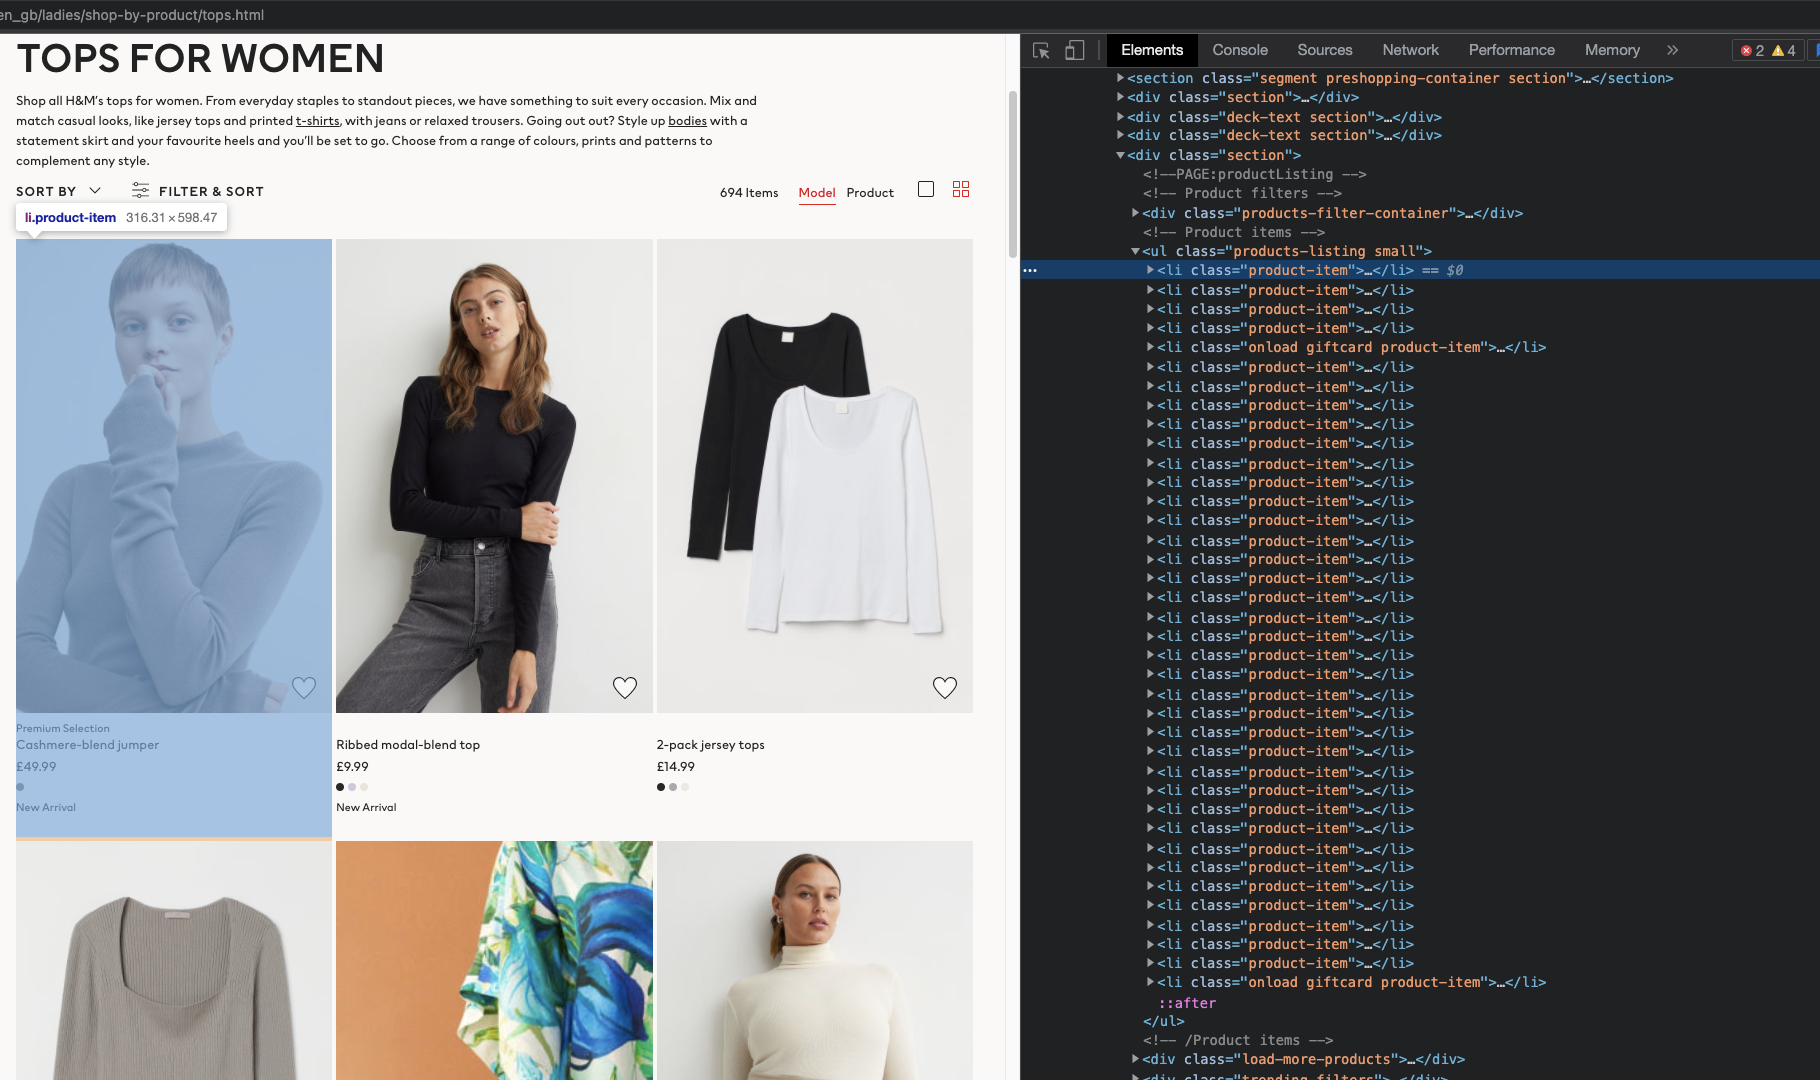

In [ ]:
item = soup.find('li',class_='product-item')
item

Within the li-tag, there is a div tag specifying the details of the item (class "item-details"). We can find the right tag, by not searching through the whole document (`soup.find()`), but instead searching within the li-tag (`item.find()`):

In [ ]:
item_details = item.find('div',class_="item-details")
print(item_details.prettify())

The tag is already much easier to analyze: For example, the link and name of the item seem to be coming within an h3-tag:

In [ ]:
item_heading = item_details.find('h3', class_='item-heading')
item_heading

Within the heading, the name is simply stored as the text of the a-tag. We can call up the text with `.text` (no need for `.get()` here):

In [ ]:
title = item_heading.find('a').text
title

The link to the product also comes in the same a-tag and, but in the href attribute:

In [ ]:
link = item_heading.find('a').get('href')
link

The link here is relative. Say we want to store a link to the product to find later on. For this, we need to make sure that we have an absolute link. Luckily, `urllib.parse` provides us a method to properly combine our starting url and this relative link:

In [ ]:
import urllib.parse

link_absolute = urllib.parse.urljoin(url, link) 
print("Starting url: " + url)
print("Product url (relative): " + link)
print("Product url (absolute): " + link_absolute)

We next search for the item price. We can see above, that the price comes within a span-tag, which sits in a strong-tag with class "item-price". We will now see that we don't necessarily need to specify the tag type:

In [ ]:
item_price = item_details.find(class_="item-price")
item_price

Once we have found the strong-tag, we can find the actual price within using the span tag.

In [ ]:
item_price.find('span').text

Given the structure and the class name, it might be that there are multiple prices (e.g., the regular price and a reduced price). Hence, let's make sure our code can get any prices displayed here:

In [ ]:
prices = []
for price_info in item_price.findAll('span'):
    prices.append(price_info.text)
prices

Finally, in some cases, items are tagged as "new arrivals". Let's make sure to capture this information as well:

In [ ]:
item_details.find(class_="new-product")

When running through the list of items, let's make sure that we check whether this tag exists. If yes, we'll take note:

In [ ]:
if item_details.find(class_="new-product") != None:
    print("This is a new product")

## 4. Putting it all together

Below, we loop through all the items and gather the information discussed above (name, url, prices, whether it's a new product). To do so, we make sure to `.findAll()` product items. We then print out the relevant information:

In [ ]:
i = 1
for item in soup.findAll('li',class_='product-item'):
    print("Scraping item " + str(i))
    
    # Make sure to start at the div-tag with class "item-details"
    item_details = item.find('div',class_="item-details")
    
    # Within each item detail, we can find the heading,
    # which contains the link with name and link
    item_heading = item_details.find(class_='item-heading')
    title = item_heading.find('a').text
    print("   Title of item : " + title)
    link = item_heading.find('a').get('href')
    link_absolute = urllib.parse.urljoin(url, link) 
    print("   Link to item : " + link_absolute)
    
    # We can also get the item price(s)
    item_price = item_details.find(class_="item-price")
    prices = []
    for price_info in item_price.findAll('span'):
        prices.append(price_info.text)
    print("   Prices : " + str(prices))
        
    # Finally, we find out whether the product is new or not
    new_product = False
    if item_details.find(class_="new-product") != None:
        new_product = True
    print("   New product : " + str(new_product))
    
    print("-----")
    i += 1

Do you notice an issue here? We have only gotten information on the items that have been loaded. But the website gives a "load more" button.

One way to go would be to use Selenium to `.click()` that button. Luckily, we don't need to go that far. In fact, once we click on "load more", we see that the url has a pretty neat structrue:

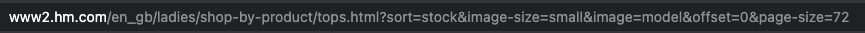

We can just crank up the "page-size" attribute of the link! But to how many products? Luckily, on top of the button, we find the answer:

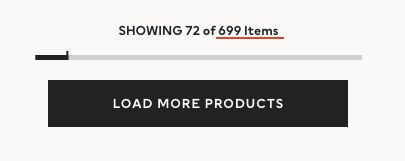

Inspection reveals that there is a h2-tag of the class "load-more-heading". Here, the attribute "data-total" contains the number of items that can be displayed:

In [ ]:
number_of_items = soup.find("h2",class_="load-more-heading").get("data-total")
number_of_items

We can grab this, and create our own url (note that loading the full website can take a little bit of time):

In [ ]:
new_url = "https://www2.hm.com/en_gb/ladies/shop-by-product/tops.html?sort=stock&image-size=small&image=model&offset=0&page-size=" \
            + number_of_items
page = requests.get(new_url,headers=headers)
soup = BeautifulSoup(page.content, "html.parser")
print(soup.prettify())

One final thing to note: If we are arbitrarily grabbing categories, there might be some with too few items to have a "load more" button - in this case, you need to make sure to check whether the button even exists.

We are now ready to scrape all the price data:

In [ ]:
i = 1
for item in soup.findAll('li',class_='product-item'):
    print("Scraping item " + str(i))
    
    # Make sure to start at the div-tag with class "item-details"
    item_details = item.find('div',class_="item-details")
    
    # Within each item detail, we can find the heading,
    # which contains the link with name and link
    item_heading = item_details.find(class_='item-heading')
    title = item_heading.find('a').text
    print("   Title of item : " + title)
    link = item_heading.find('a').get('href')
    link_absolute = urllib.parse.urljoin(url, link) 
    print("   Link to item : " + link_absolute)
    
    # We can also get the item price(s)
    item_price = item_details.find(class_="item-price")
    prices = []
    for price_info in item_price.findAll('span'):
        prices.append(price_info.text)
    print("   Prices : " + str(prices))
        
    # Finally, we find out whether the product is new or not
    new_product = False
    if item_details.find(class_="new-product") != None:
        new_product = True
    print("   New product : " + str(new_product))
    
    print("-----")
    i += 1

## 5. Using our scraping tool

Instead of just printing out the gathered data, we usually want to create a dataframe (which we could then store as a csv). Let's adjust the code from above slightly:

In [ ]:
# We create lists to capture the data of each item
titles = []
links = []
price_lists = []
new_product_indicators = []
for item in soup.findAll('li',class_='product-item'):
    item_details = item.find('div',class_="item-details")
    
    item_heading = item_details.find(class_='item-heading')
    title = item_heading.find('a').text
    titles.append(title)
    
    link = item_heading.find('a').get('href')
    link_absolute = urllib.parse.urljoin(url, link) 
    links.append(link_absolute)
    
    item_price = item_details.find(class_="item-price")
    prices = []
    for price_info in item_price.findAll('span'):
        prices.append(price_info.text)
    price_lists.append(prices)

    new_product = False
    if item_details.find(class_="new-product") != None:
        new_product = True
    new_product_indicators.append(new_product)

# We convert these lists into a dataframe based on a dictionary approach
itemdf = pd.DataFrame({'titles': titles, 'links': links, 'prices': price_lists, 'new_product': new_product_indicators})

In [ ]:
itemdf

We can now clean and analyze our dataset.

For example, we can check whether there actually were any items with multiple price tags:

In [ ]:
count = 0
for prices in itemdf['prices']:
    if len(prices) > 1:
        count += 1
count

We could also take a look at average prices:

In [ ]:
average_price = 0
for prices in itemdf['prices']:
    price = prices[0]
    price = float(price[1:])
    average_price += price
average_price /= len(itemdf)
average_price

Finally, let's see which percentage of goods are new arrivals:

In [ ]:
count = 0
for new_indic in itemdf['new_product']:
    if new_indic:
        count += 1
count / len(itemdf)